# Define and map land surface phenology metrics across Australia

Including the trends in the phenometrics


In [1]:
%matplotlib inline

import sys
import pickle
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import geopandas as gpd
import contextily as ctx
import pymannkendall as mk
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.interpolate import griddata

sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
# from phenology import extract_peaks_troughs, phenometrics

%load_ext autoreload
%autoreload 2

## Analysis Parameters


In [2]:
# product='GIMMS-PKU'
# product='AusENDVI-clim'
product='AusENDVI-clim_MCD43A4'
# product='GIMMS-PKU_2022'
# product='GIMMSv1.1'
# product='GIMMSv1.2'
# product='MCD43A4'
# product='Landsat'
# product='AusENDVI-clim_2000'

timeseries_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_NDVI_'+product+'.pkl'
save_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_'+product+'_phenometrics.pkl'

# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_regions_modified.geojson'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'

# var='REG_NAME_7'
var='SUB_NAME_7'

# region_type = 'IBRA_regions'
region_type = 'IBRA_subregions'

years='1982-2022'

## Open data

In [3]:
with open(timeseries_file, 'rb') as f:
    results = pickle.load(f)

gdf = gpd.read_file(ecoregions_file)

## Extract phenometrics 

<!-- import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def double_logistic_function(t, wNDVI, mNDVI, S, A, mS, mA):
    sigmoid1 = 1 / (1 + np.exp(-mS * (t - S)))
    sigmoid2 = 1 / (1 + np.exp(mA * (t - A)))
    seasonal_term = sigmoid1 + sigmoid2 - 1
    return wNDVI + (mNDVI - wNDVI) * seasonal_term

def weight_function(t, S, A, r):
    tr = 100 * (t - S) / (A - S)
    tr = np.clip(tr, 0, 100)
    return np.exp(-np.abs(r) / (1 + tr / 10))

def fit_curve(t, ndvi_observed):
    initial_guess = [np.min(ndvi_observed), np.max(ndvi_observed), np.mean(t), np.mean(t), 1, 1]
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, maxfev=10000)
    residuals = ndvi_observed - double_logistic_function(t, *params)
    weights = weight_function(t, params[2], params[3], residuals)
    params, _ = curve_fit(double_logistic_function, t, ndvi_observed, p0=initial_guess, sigma=weights, maxfev=10000)
    return params

doys = ndvi_cycle.time.dt.dayofyear.values[2:]
doys_frac = doys/365
values = ndvi_cycle.values[2:]

##Fit the curve
parameters = fit_curve(doys_frac, values)

##Plot the observed NDVI values
plt.scatter(doys, values, label='Observed NDVI')

##Generate points for the fitted curve
t_fit = np.linspace(min(doys_frac), max(doys_frac), 365)
ndvi_fit = double_logistic_function(t_fit, *parameters)

##Plot the fitted curve
plt.plot(t_fit*365, ndvi_fit, label='Fitted Curve', color='red')

plt.xlabel('Day of the Year')
plt.ylabel('NDVI')
plt.legend()
plt.title('Double Logistic Curve Fitting for NDVI Observations')
plt.show() -->

In [4]:
if product=='GIMMSv1.1':
    del results['Coral Se']


In [9]:
from phenology_pixel import _extract_peaks_troughs, xr_phenometrics

In [7]:
# _extract_peaks_troughs(results['Murgenell'].expand_dims(latitude=[-33.0],longitude=[135.0]))

In [71]:
p = xr_phenometrics(results['Weipa Plateau'].expand_dims(latitude=[-33.0],longitude=[135.0])).compute()

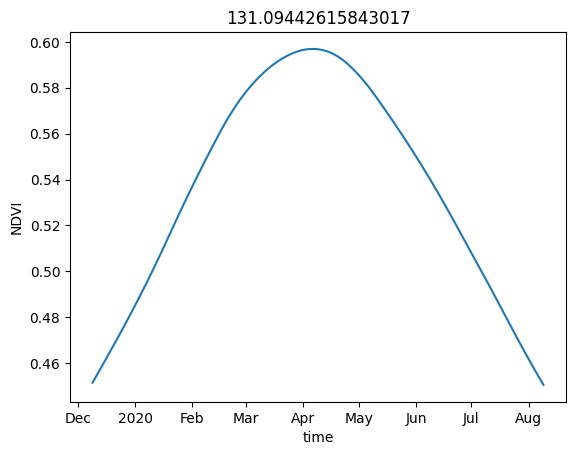

In [72]:
from datetime import datetime
sos = pd.Timestamp(datetime.strptime(f'{int(p.sel(index=37).SOS_year)} {int(p.sel(index=37).SOS)}', '%Y %j'))
eos=pd.Timestamp(datetime.strptime(f'{int(p.sel(index=37).EOS_year)} {int(p.sel(index=37).EOS)}', '%Y %j'))

results['Weipa Plateau'].sel(time=slice(sos,eos)).plot()
plt.title(results['Weipa Plateau'].sel(time=slice(sos,eos)).integrate('time', datetime_unit='D').values.item());

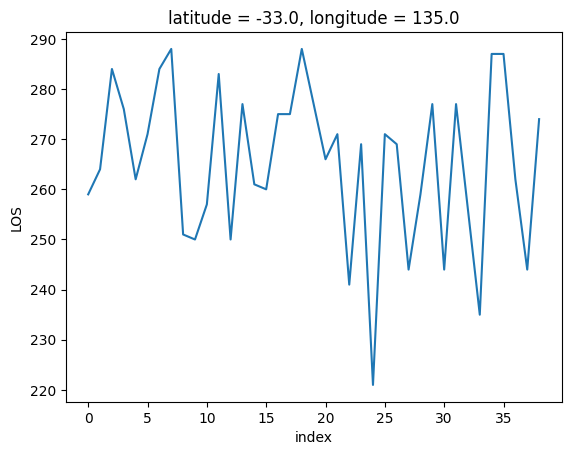

In [73]:
p.LOS.plot()
# plt.ylim(300,360)

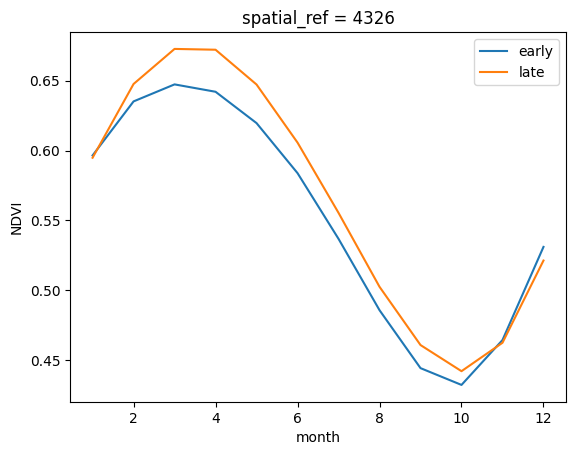

In [77]:
early = results['Weipa Plateau'].sel(time=slice('1982','2000')).groupby('time.month').mean()
late = results['Weipa Plateau'].sel(time=slice('2001','2022')).groupby('time.month').mean()

early.plot(label='early')
late.plot(label='late')
plt.legend();

In [ ]:
eco_regions_phenometrics = phenometrics(results,
                                        rolling=90,
                                        distance=90,
                                        prominence='auto',
                                        plateau_size=10,
                                        amplitude=0.20
                                       )

## Save results

In [ ]:
with open(save_file, 'wb') as f:
    pickle.dump(eco_regions_phenometrics, f)

## Plot one ecoregion's phenometrics

For testing

In [ ]:
# # eco_regions_phenometrics[k][['SOS_year','SOS','POS','EOS_year','EOS', 'LOS']]
# eco_regions_phenometrics[k][['SOS','POS','EOS', 'LOS']].quantile(q=0.5, interpolation='lower')

In [ ]:
# k='Southern Downs'
# k = 'West Warrego'
# k = 'Warrego Plains'
k = 'Newcastle'
# k = 'Strzelecki Ranges'
# k = 'Northern Slopes rainfed crop'
# k='Daintree-Bloomfield irrigated crop'
with plt.style.context('ggplot'):
    fig,ax = plt.subplots(1,1, figsize=(15,4))
    
    results[k].plot(ax=ax, c='tab:blue')
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].SOS.values, eco_regions_phenometrics[k].SOS_year.values)],
               y=eco_regions_phenometrics[k].vSOS,
              c='tab:green', label='SOS')
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].EOS.values, eco_regions_phenometrics[k].EOS_year.values)],
               y=eco_regions_phenometrics[k].vEOS,
              c='tab:purple', label='EOS')
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].POS.values, eco_regions_phenometrics[k].POS_year.values)],
                   y=eco_regions_phenometrics[k].vPOS,
                  c='black', label='POS')
        
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].TOS.values, eco_regions_phenometrics[k].TOS_year.values)],
               y=eco_regions_phenometrics[k].vTOS,
              c='tab:orange', label='TOS')
    
    ax.set_xlabel(None)
    ax.set_ylabel('NDVI')
    ax.set_title(k, fontsize=15)
    ax.legend()
    plt.tight_layout()

## Plot a subset of all regions

This will plot the time-series of 75 regions so we can see how the phenology code is performing across diverse landscapes

In [ ]:
keys_list = list(eco_regions_phenometrics.keys())
keys_list.sort()
length = len(keys_list)
keys_to_plot = [keys_list[k] for k in range(0,length,int(length/75))]
    
with plt.style.context('ggplot'):
    fig,axes = plt.subplots(len(keys_to_plot),1, figsize=(11,100), sharex=True, layout='constrained')
    for k,ax in zip(keys_to_plot, axes.ravel()):
    
        results[k].plot(ax=ax, c='tab:blue')
        ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].SOS.values, eco_regions_phenometrics[k].SOS_year.values)],
                   y=eco_regions_phenometrics[k].vSOS,
                  c='tab:green', label='SOS')
        
        ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].EOS.values, eco_regions_phenometrics[k].EOS_year.values)],
                   y=eco_regions_phenometrics[k].vEOS,
                  c='tab:purple', label='EOS')
        
        ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].POS.values, eco_regions_phenometrics[k].POS_year.values)],
                       y=eco_regions_phenometrics[k].vPOS,
                      c='black', label='POS')
            
        ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].TOS.values, eco_regions_phenometrics[k].TOS_year.values)],
                   y=eco_regions_phenometrics[k].vTOS,
                  c='tab:orange', label='TOS')
        
        ax.set_xlabel(None)
        # ax.set_ylabel('NDVI')
        ax.set_title(k, fontsize=8)
        # ax.legend()
    

## Summarise average phenometrics with maps of Australia

In [ ]:
means = []
for k in eco_regions_phenometrics.keys():
    df = eco_regions_phenometrics[k]

    #include a column counting the number of seasons
    df['n_seasons'] = len(df)
    
    mean_df = df.quantile(q=0.5, interpolation='lower') # median
    mean_df = mean_df.rename({i:'mean_'+i for i in mean_df.index}).to_frame().transpose()
    mean_df[var] = k

    mean_gdf = gdf.merge(mean_df, on=var)
    means.append(mean_gdf)
    
pheno_means = pd.concat(means).reset_index(drop=True)

In [ ]:
# pheno_means[['mean_SOS', 'geometry', var]].explore(column='mean_SOS', cmap='twilight')

### Plot

In [ ]:
fig,axes=plt.subplots(4,3, figsize=(11,11), sharey=True, sharex=True, layout='constrained')
pheno_stats=['SOS','vSOS', 'LOS', 
             'POS', 'vPOS', 'ROG',
             'EOS', 'vEOS', 'ROS',
             'IOS', 'vTOS', 'AOS',
      ]
cmaps = ['twilight', 'gist_earth_r', 'viridis',
         'twilight', 'gist_earth_r','magma',
         'twilight', 'gist_earth_r', 'magma_r',
         'inferno', 'gist_earth_r','plasma'
        ]
for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):
    if "v" not in pheno:
        vmin, vmax=0, 365
        label='DOY'
    if "v" in pheno:
        vmin,vmax=0.1, 0.85
        label='NDVI'
    if 'LOS' in pheno:
        vmin, vmax=160, 300
        label='days'
    if 'AOS' in pheno:
        vmin, vmax=0.05, 0.4
        label='NDVI'
    if 'IOS' in pheno:
        vmin, vmax=20, 200
        label='NDVI/\n season'
    if 'ROG' in pheno:
        vmin, vmax=0.00025, 0.0025
        label='NDVI/\nday'
    if 'ROS' in pheno:
        vmin, vmax=-0.0025, -0.00025
        label='NDVI/\nday'
    im=pheno_means.plot(column='mean_'+pheno, ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)
    ctx.add_basemap(im, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    #need to create colorbar manually to have label on top
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
    ax_cbar.ax.set_title(label, fontsize=8)
    ax.set_title(f'{pheno}, {years}')

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/average_phenometrics_map_{region_type}_{product}.png',
            bbox_inches='tight', dpi=300)

## Plot number of seasonal cycles

In [ ]:
vmin,vmax=33,45
cmap='RdYlBu'
fig,ax=plt.subplots(1,1, figsize=(8,8), layout='constrained')
im=pheno_means.plot(column='mean_n_seasons',  legend=False, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
ctx.add_basemap(im, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
#need to create colorbar manually to have label on top
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
ax_cbar.ax.set_title('number of\nseasons', fontsize=8)
ax.set_title(f'Number of full vegetation cycles identified ({years})')

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/num_seasons_{region_type}_{product}.png',
            bbox_inches='tight', dpi=300);

## Extract robust trends


### First remove all cropping regions

Calibration issues in irrigated regions; trends in rainfed cropping regions are confounded by direct human intervention

Should I add random noise to account for residual sensor miscalibration?

```
noise = np.random.random(img.shape) * 0.01
noisy_img = img + noise
```

In [ ]:
eco_regions_phenometrics = {k:v for k, v in eco_regions_phenometrics.items() if not 'crop' in k}

In [ ]:
trends_dfs = []
pheno_stats=['SOS','vSOS','LOS','POS','vPOS','AOS',
             'EOS', 'vTOS','vEOS','ROG','ROS', 'IOS']
i=0
for k in eco_regions_phenometrics.keys():
    print("Feature {:02}/{:02}\r".format(i + 1, len(range(0, len(eco_regions_phenometrics)))), end="")
    
    df = eco_regions_phenometrics[k]
    trends = {}
    for pheno in pheno_stats:
        
        result = mk.original_test(eco_regions_phenometrics[k][pheno], alpha=0.1)
        # result = stats.linregress(x=df.index, y=df[pheno])
        trends[pheno+'_p-value'] = result.p
        trends[pheno+'_slope'] = result.slope
        trends[pheno+'_intercept'] = result.intercept
        trends[var] = k

    trend_df=pd.DataFrame(trends, index=range(0,1))
    trends_dfs.append(gdf.merge(trend_df, on=var))
    i+=1

pheno_trends = pd.concat(trends_dfs).reset_index(drop=True)

### Plot

> Warning, this takes a very long time. I think due to the hatch plotting

In [ ]:
fig,axes=plt.subplots(4,3, figsize=(11,11),  layout='constrained')#sharey=True, sharex=True,
pheno_stats=['SOS','vSOS', 'LOS', 
             'POS', 'vPOS', 'ROG',
             'EOS', 'vEOS', 'ROS',
             'AOS', 'vTOS', 'IOS'
      ]
cmaps = ['coolwarm','BrBG','PRGn',
         'coolwarm','BrBG','Spectral',
         'coolwarm','BrBG','Spectral_r',
         'PiYG','BrBG','PuOr'
        ]
for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):
   
    if "v" not in pheno:
        vmin, vmax=-1.5,1.5
        label='days/\nyear'
    if "v" in pheno:
        vmin,vmax=-0.0015, 0.0015
        label='NDVI/\nyear'
    if 'LOS' in pheno:
        vmin, vmax=-1.5, 1.5
        label='days/\nyear'
    if 'AOS' in pheno:
        vmin, vmax=-0.002, 0.002
        label='NDVI\nyear'
    if 'ROG' in pheno:
        vmin, vmax=-2.0e-05, 2.0e-05
        label='NDVI/day/\nyear'
    if 'ROS' in pheno:
        vmin, vmax=-2.0e-05, 2.0e-05
        label='NDVI/day/\nyear'
    if 'IOS' in pheno:
        vmin, vmax=-0.5, 0.5
        label='NDVI/\nseason/\nyear'

    # im=pheno_trends.plot(column=pheno+'_slope', ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)
    
    significant = pheno_trends[pheno_trends[pheno+'_p-value'] <= 0.05]
    not_significant = pheno_trends[pheno_trends[pheno+'_p-value'] > 0.05]
    
    im=significant.plot(column=pheno+'_slope', ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax, hatch='....')     
    not_significant.plot(column=pheno+'_slope', ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)     

    ctx.add_basemap(im, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #need to create colorbar manually to have label on top
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
    ax_cbar.ax.set_title(label, fontsize=8)
    ax.set_title(f'{pheno}, {years}')
    print(pheno)
    
# axes[3,2].axis('off');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/trends_phenometrics_map_{region_type}_{product}.png',
            bbox_inches='tight', dpi=300)

In [ ]:
# fig,axes=plt.subplots(1,1, figsize=(11,11),  layout='constrained')
# significant.plot(column='IOS_slope',ax=ax, legend=False, cmap='coolwarm', vmin=-1.5, vmax=1.5, hatch='XXX')   
# not_significant.plot(column='SOS_slope',ax=ax, legend=False, cmap='coolwarm', vmin=-1.5, vmax=1.5);

## Facet plots of phenograms

Maybe instead group the plots by similar land covers e.g. Rainfed cropping regions, forested regions, grasslands

### Gridded phenology

In [ ]:
#create a grid
xi = np.linspace(1, 12, 12) #months
yi = np.linspace(1982, 2022, 41) #years
Xi, Yi = np.meshgrid(xi, yi) #grid coords

with plt.style.context('default'):
    fig, axes = plt.subplots(20,7, figsize=(13,30), sharex=True)
    for ax, (k,v) in zip(axes.reshape(-1), results.items()):
        dss = v.resample(time='MS', loffset=pd.Timedelta(14, 'd')).mean()
        zi = griddata(points=(dss.time.dt.month, dss.time.dt.year),
                      values=dss.values,
                      xi=(xi[None, :], yi[:, None]),
                      method='nearest')
        
        sp = ax.contourf(zi, levels=75, cmap='gist_earth_r')
        # clb = fig.colorbar(sp, ax=axes, shrink=0.65, format="%0.2f")
        # clb.ax.set_title('NDVI', fontsize=5)
        ax.set(xticks=range(0,12))
        ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=8);
        ax.set(yticks=range(0,41))
        ax.set_yticklabels([str(y) for y in range(1982,2023)], fontsize=8);
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10))
        ax.set_title(k, fontsize=6);
    plt.tight_layout();

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/phenology_grids_{region_type}_{product}.png',
          bbox_inches='tight', dpi=300);

### Before/after seasonal curves

The better way to do this would be to recreate the seasonal cycles using the phenology stats, then we could have time-series that extend beyong just the year

In [ ]:
plt.style.use('ggplot')
fig, axes = plt.subplots(20,7, figsize=(15,30), sharex=True)
for ax, (k,v) in zip(axes.reshape(-1), results.items()):
    early_clim = v.sel(time=slice('1982', '2000')).groupby('time.month').mean()
    late_clim = v.sel(time=slice('2001', '2021')).groupby('time.month').mean()
    early_clim.plot(label='1982-2001', ax=ax)
    late_clim.plot(label='2002-2021', ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    #ax.legend()
    ax.set_title(k, fontsize=6)
    ax.set(xticks=range(1,13))
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=8);
fig.supylabel('NDVI')
plt.tight_layout()

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/phenology_curves_{region_type}_{product}.png',
          bbox_inches='tight', dpi=300);